<h1> Εργασία 2 - Αναγνώριση Προτύπων-Μηχανική Μάθηση</h1>

<h2>Φαραώ Γεώργιος 1115201700177</h2>

In [ ]:
# Mount the google drive to have access to the files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import the libraries we will need
import numpy as np
import sys
import os
import cv2
from numpy import dot
import numpy.linalg as LA
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.linalg import eigh as leigh
import scipy.sparse.linalg as sp
from sklearn.linear_model import Ridge
from PIL import Image
%matplotlib inline

# __Ερώτημα 1 - Προ-επεξεργασία, μείωση διαστάσεων, και οπτικοποίηση και ταξινόμηση εικόνων__

### __PART I__

In [ ]:
path = "/content/gdrive/MyDrive/MachineLearning/images/"

def loadImages(path):
  image_list=[]
  image_array=[]
  categ_list=[]

  #firstwe get each image in the folder
  for image in os.listdir(path):
    if os.path.isfile(path+image):
      res = Image.open(path+image)                  #open image and then resize it
      res = res.resize((100,100),Image.ANTIALIAS)

      image_list.append(res)                      #append resized image in a list
      image_array.append(np.reshape(res,(100*100*3)))       #list to store the images later used in pca
      
      #create a list with the categories of the images
      if image[0]=='W':      
        categ_list.append(0)
      elif image[0]=='F':    
        categ_list.append(1)
      else:
        categ_list.append(2)

  image_nparray = np.array(image_array)
  return image_nparray,image_list,categ_list

img_arr, img_list,categ_list = loadImages(path)

#the array we need is the inverted of the one that the function returns
img_arrΤ=img_arr.T
img_arrT_meaned = img_arrΤ - np.mean(img_arrΤ)    #normalize the data
covMatrix = np.cov(img_arrT_meaned, rowvar=True)    #calculate covariance matrix


### __PART II__

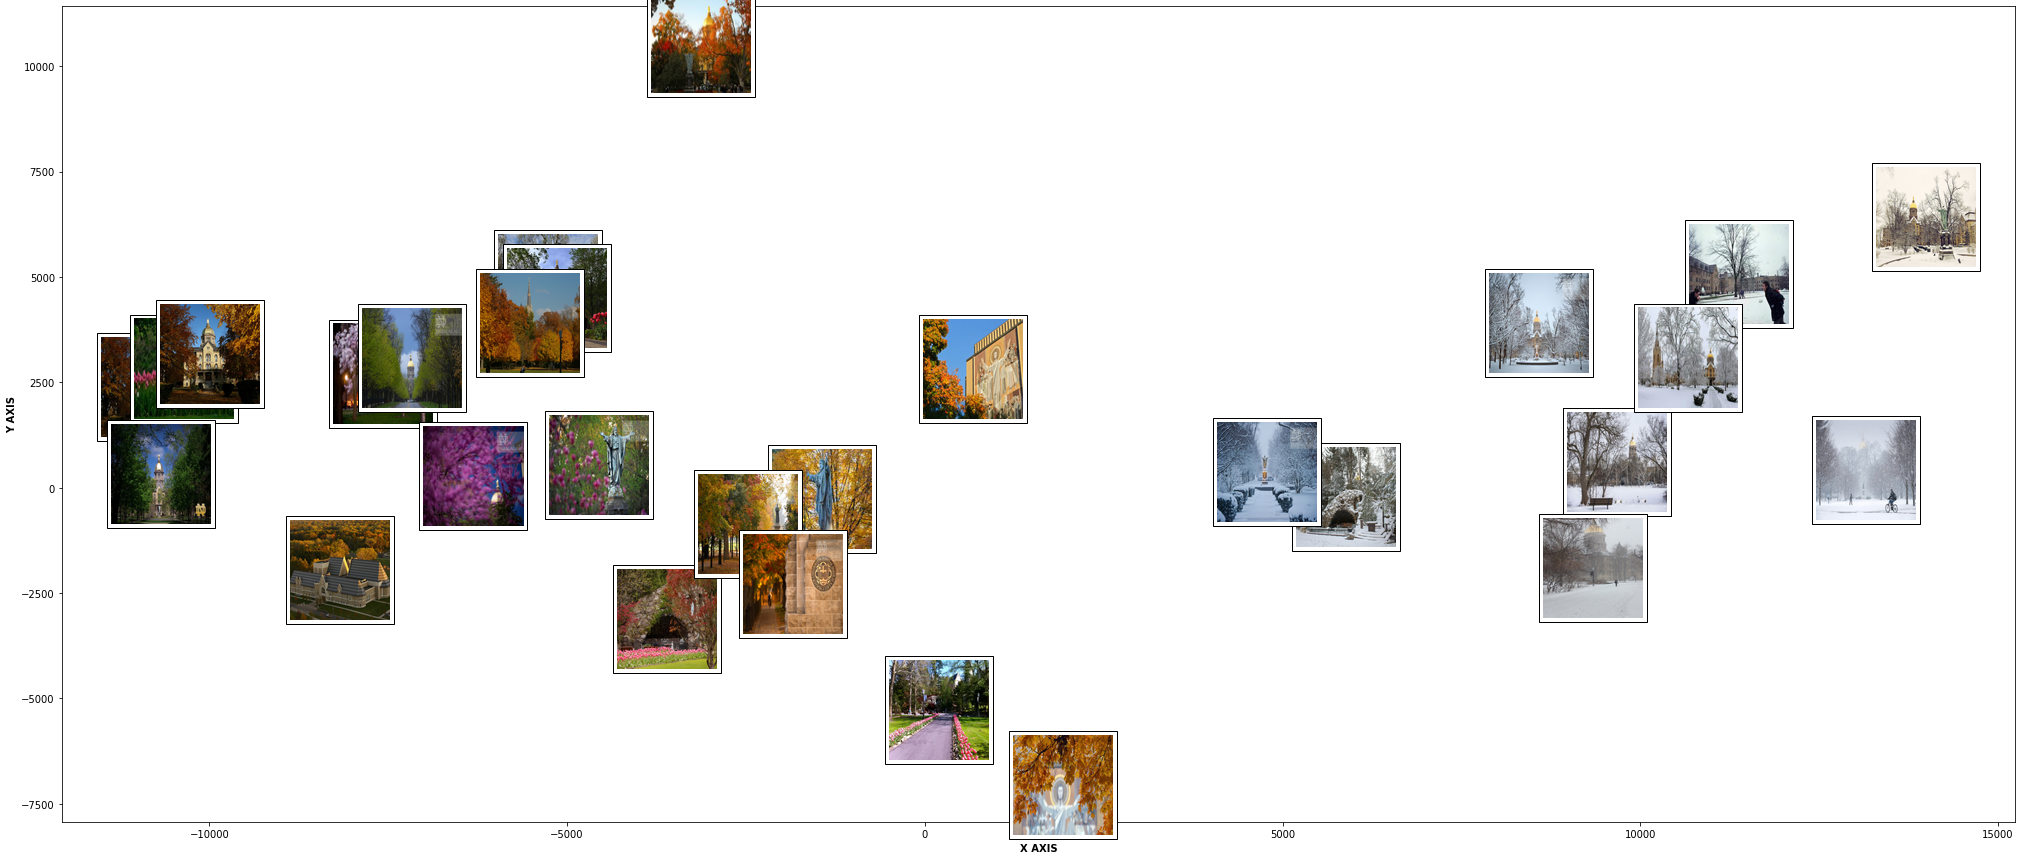

In [ ]:
#we use eighs from scipy since covariance matrix is 30000x30000 and np.eigh crashes 
from scipy.linalg import eigh as leigh
import scipy.sparse.linalg as sp

def PCA_ImageSpaceVisualization(img_arr):

  #calculate eigen values and vectors
  eigValue, eigVector = sp.eigsh(covMatrix,30,which='LA')     #we calcuate all 30 in order to use them later to find the explained variance for question V2

  #THe two lines bellow are based on this article: https://vitalflux.com/pca-explained-variance-concept-python-example/
  total_egnvalues = sum(eigValue)
  explained_var = [(i/total_egnvalues) for i in sorted(eigValue, reverse=True)]
  #####################

  #now we will find top 2 eigVectors, based on the code from lab 6
  k=2

  aDict={}
  selectededEigenVectors=[]

  for a in zip(eigValue, eigVector.T):
    aDict[abs(a[0])]=a[1]

  n=0
  for aKey in sorted(aDict,reverse=True): ## sort by the key
    n+=1
    selectededEigenVectors+=[aDict[aKey].reshape(30000,1)] ## select the eigenvectors
    if n==k:
      break
 
  w=np.hstack(selectededEigenVectors)
  final = w.T.dot(img_arr)    #final data

  #now we will create the plot
  first_comp= [entry for entry in final[0]]     #first we get each component from the 2 dimensions
  second_comp= [entry for entry in final[1]]

  fig,ax= plt.subplots(figsize=(35,15))
  ax.scatter(first_comp,second_comp)
  ax.set_ylabel('Y AXIS',fontweight='bold')
  ax.set_xlabel('X AXIS',fontweight='bold')

  #The following code is based on this post 
  #https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
  toshow = zip(first_comp,second_comp,img_list)
  for a,b,image in toshow:
    
    res= AnnotationBbox(OffsetImage(image),(a,b))
    ax.add_artist(res)

  return final,explained_var
pca_res, expl_var= PCA_ImageSpaceVisualization(img_arrT_meaned)

### __PART III__


#### __Τι σημαίνει όταν εικόνες βρίσκονται κοντά σε αυτό το χώρο δύο διαστάσεων που απεικονίζεται στο παραπάνω plot;__
Το ότι οι εικόνες βρίσκονται κοντά στον χώρο σημαίνει ότι οι τιμές των εικονοστοιχείων κάθε εικόνας μένουν κοντά (σε μέτρο) όταν μειώνουμε τις διαστάσεις τους και τις μετασχηματίζουμε σε ιδιοτιμές. Πραγματοποιώντας PCA κατηγοριοποιούμε τις εικόνες ανάλογα με την ομοιότητα τους. Ετσι βλέπουμε και από το πλοτ ότι οι εικόνες κατηγοριοποιούνται ανάλογα με τα χρώματά τους.

#### __Τι σημαίνει όταν εικόνες απέχουν πολύ;__
Το ότι απέχουν οι εικόνες μεταξύ τους σημαίνει ότι έχουν αρνητική συνδυασπορά, δήλαδή όταν μειώνεται η τιμή ενός, αυξάνεται η τιμή του άλλου ή το ανάποδο. Έτσι στο πλοτ παρατηρείται μεγάλη διαφορά χρωμάτων, άρα και των εποχών, μεταξύ των εικόνων που απέχουν πολύ.


#### __Μπορούμε να γενικεύσουμε αυτά τα συμπεράσματα για τον αρχικό χώρο των εικόνων ο οποίος είναι πολύ μεγάλης διάστασης;__

Μπορούμε να γενικεύσουμε τα συμπεράσματά μας και στον χώρο πολλών διαστάσεων, καθώς χρησιμοποιώντας το PCA τα δεδομένα μετασχηματίζονται σε 2 διαστάσεις και άρα τα συμπεράσματα που βγάζουμε ισχύουν και για τα δεδομένα μεγαλύτερων διαστάσεων, που όμως εκεί λόγω της πολυπλοκότητας τους δεν μπορούμε να τα αντιληφθούμε.

### __PART IV__

#### __Οι εικόνες που αντιστοιχούν σε μία από τις εποχές τείνουν να ομαδοποιούνται πιο κοντά από ότι οι υπόλοιπες; Γιατί συμβαίνει αυτό;__
Πράγματι παρατηρούμε στο πλοτ ότι εικόνες που αντιστοιχούν στην ίδια εποχή ομαδοποιούνται πιο κοντά απ'ότι οι υπόλοιπες. Για να καταλάβουμε γιατί συμβαίνει αυτό πρέπει πρώτα να κατανοήσουμε την λειτουργία του PCA:<br>
Άρχικά παίρνουμε ως είσοδο τον πίνακα των εικόνων μεγέθους 30x100x100x3. Υπολογίζουμε τον meanVector τον οποίο χρησιμοποιούμε για τον υπολογισμό του scatter matrix. Υπολογίζουμε τον scatter matrix αντί το covariance για να ελαχιστοποιήσουμε το κόστος, αφού οδηγούν και οι δύο στα ίδια ιδιοδιανύσματα.<br>
 Στην συνέχεια υπολογίζουμε τις ιδιοτιμές και τα ιδιοδιανύσματα του πίνακα αυτού, καθώς με αυτά μπορούμε να απεικονίσουμε τα δεδομένα μας στομ χώρο σε ευθείες που έχουν πληροφορίες σχετικά με αυτά.<br> Έπειτα ταξινομούμε τις ιδιοτημές κατα φθήνουσα σειρά, επιλέγουμε τις Κ μεγαλύτερες και μετασχηματίζουμε τα δεδομένα μας στις διαστάσεις που ορίζουν αυτές.<br> Τελικά παίρνουμε τα τελικά δεδομένα και φτίαχνουμε ένα 2D plot.<br> Σαν αποτέλσμα του PCA, έχουμε μειώσει τις διαστάσεις των δεδομένων μας και καταλήγουμε σε δύο που κρατάνε την περισσότερη πληροφορία σχετικά με τα χρώματα των εικόνων.

### __PART V__

#### __Για τα αρχικά δεδομένα__




In [ ]:
#split our data, Train size is 80% and Test size is 20%
xtrain, xtest, ytrain,ytest = train_test_split(img_arr,categ_list,test_size=0.2,random_state=42,stratify=categ_list)

__1 Πλησιέστερος Γείτονας(1ΝΝ)__

In [ ]:
classif= KNeighborsClassifier(n_neighbors=1)
classif.fit(xtrain, ytrain)
res = classif.predict(xtest)
score = accuracy_score(ytest,res)
print("Score of initial images 1NN:",100*score,"%")

Score of initial images 1NN: 83.33333333333334 %


__3 Πλησιέστεροι Γείτονες(3NN)__

In [ ]:
classif= KNeighborsClassifier(n_neighbors=3)
classif.fit(xtrain, ytrain)
res = classif.predict(xtest)
score = accuracy_score(ytest,res)
print("Score of initial images 3NN:",100*score,"%")

Score of initial images 3NN: 66.66666666666666 %


#### __Για τα αποτελέσματα του PCA__

In [ ]:
xtrain, xtest, ytrain,ytest = train_test_split(pca_res.T,categ_list,test_size=0.2,random_state=1,stratify=categ_list)

__1 Πλησιέστερος Γείτονας(1ΝΝ)__

In [ ]:
classif= KNeighborsClassifier(n_neighbors=1)
classif.fit(xtrain, ytrain)
res = classif.predict(xtest)
score = accuracy_score(ytest,res)
print("Score of PCA 1NN:",100*score,"%")

Score of PCA 1NN: 66.66666666666666 %


__3 Πλησιέστεροι Γείτονες(3NN)__

In [ ]:
classif= KNeighborsClassifier(n_neighbors=3)
classif.fit(xtrain, ytrain)
res = classif.predict(xtest)
score = accuracy_score(ytest,res)
print("Score of PCA 3NN:",100*score,"%")

Score of PCA 3NN: 66.66666666666666 %


### __V1 5-fold cross validation__

Στην KFold συνάρτηση θα χρησιμοποιήσουμε shuffle=True έτσι ώστε κάθε φορά που τρέχουμε την συνάρτηση να γίνονται shuffle τα δεδομένα μας και να υπάρχει τυχαιότητα

#### __Για τα αρχικά δεδομένα__

__1 Πλησιέστερος Γείτονας(1ΝΝ)__

In [ ]:
score=cross_val_score(KNeighborsClassifier(n_neighbors=1),img_arr, categ_list, cv=KFold(n_splits=5, shuffle=True), scoring='accuracy' )
final_score = score.mean()
print("Score of initial images 1NN:",100*final_score,"%")

Score of initial images 1NN: 73.33333333333333 %


__3 Πλησιέστεροι Γείτονες(3NN)__

In [ ]:
score=cross_val_score(KNeighborsClassifier(n_neighbors=3),img_arr, categ_list, cv=KFold(n_splits=5, shuffle=True), scoring='accuracy' )
final_score = score.mean()
print("Score of initial images 3NN:",100*final_score,"%")

Score of initial images 3NN: 66.66666666666667 %


#### __Για τα αποτελέσματα του PCA__

__1 Πλησιέστερος Γείτονας(1ΝΝ)__

In [ ]:
score=cross_val_score(KNeighborsClassifier(n_neighbors=1),pca_res.T, categ_list, cv=KFold(n_splits=5,shuffle=True), scoring='accuracy' )
final_score = score.mean()
print("Score of PCA 1NN:",100*final_score,"%")

Score of PCA 1NN: 70.0 %


__3 Πλησιέστεροι Γείτονες(3NN)__

In [ ]:
score=cross_val_score(KNeighborsClassifier(n_neighbors=3),pca_res.T, categ_list, cv=KFold(n_splits=5,shuffle=True), scoring='accuracy' )
final_score = score.mean()
print("Score of PCA 1NN:",100*final_score,"%")

Score of PCA 1NN: 63.33333333333334 %


#### __Final Results__

Χωρίς KFold:<br>


*   Initial images 1NN: 83.33333333333334 %
*   Initial images 3NN: 66.6 %
*   PCA 1NN: 66.6 %
*   PCA 3NN: 66.6 %
<br>

Με KFOLD(k=5) (τα αποτελέσματα μπορεί να διαφέρουν ανά εκτέλεση λόγω του shuffle):<br>

*   Initial images 1NN: 73.3 %
*   Initial images 3NN: 66.6%
*   PCA 1NN: 70.0 %
*   PCA 3NN: 63.3 %





Για την υλοποίηση του κώδικα για ΚΝΝ και cross validation βασίστηκα στο documentation του scikit για τις συναρτήσεις που χρησιμοποίησα και τα παραδείγματα που περιέχει για κάθε μια.

### __Πώς θα προσδιορίσετε τη διάσταση των χαρακτηριστικών που θα εξάγετε μέσω της PCA;__

Από το εργαστήριο του μαθήματος

> Για την ορθή χρήση της χρήσης PCA είναι πολύ σημαντική η ικανότητα εκτίμησης του αριθμού των στοιχείων που απαιτούνται για την περιγραφή των δεδομένων. Αυτό μπορεί να προσδιοριστεί εξετάζοντας το σωρευτικό λόγο της εξηγούμενης διακύμανσης σε σχέση με τον αριθμού των κυρίων συνιστωσών



[0.4703024303555865, 0.09341625514421203, 0.05906063716922036, 0.047988487469254215, 0.03869625123563883, 0.032701386518021375, 0.027358992255261644, 0.024312739832126885, 0.01966565377688247, 0.01779817827482882]


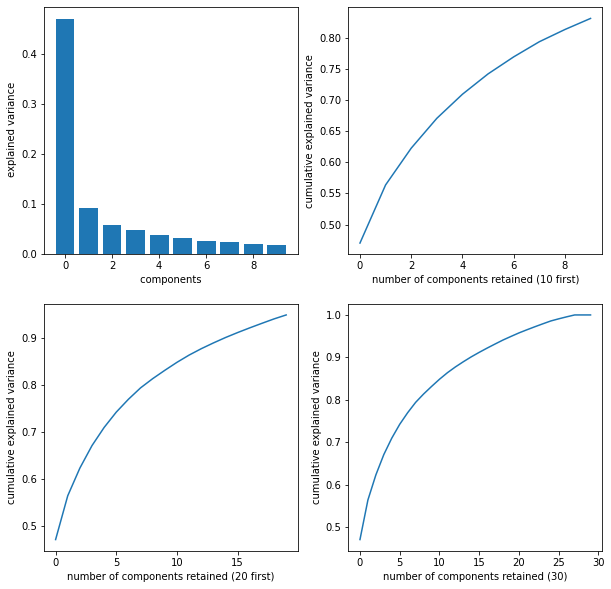

In [ ]:
#This block of code is from lab 6
print(expl_var[:10])
cumExplainedVar=np.cumsum(expl_var)
# res = pca_res.explained_variance_ratio_
# first_comp= [entry for entry in pca_re[0]]
plt.figure(figsize=(10, 10))
numOfComp=10
plt.subplot(2, 2, 1)
plt.bar(range(numOfComp),np.array(expl_var)[:numOfComp])
plt.xlabel(' components ')
plt.ylabel(' explained variance');


plt.subplot(2, 2, 2)
plt.plot(cumExplainedVar[:10])
plt.xlabel('number of components retained (10 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 3)
plt.plot(cumExplainedVar[:20])
plt.xlabel('number of components retained (20 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 4)
plt.plot(cumExplainedVar)
plt.xlabel('number of components retained (30)')
plt.ylabel('cumulative explained variance');

plt.show()




Από τα διαγράμματα μπορούμε να συμπεράνουμε ότι με την διαγραμματική παρουσίαση των δεδομένων του αρχικού προβλήματος και τον υπολογισμό του covariance αυτών μπορει να γίνει επιλογή του σωστού αριθμού συνιστωσών και έτσι να καταλήξουμε στην διάσταση των χαρακτηριστικών που θα εξάγουμε μέσω της PCA.

Παρατηρούμε ότι από τις 2 πρώτες συνιστώσες εξάγουμε περίπου το 56%(47%+9.3%) της διακύμανσης των δεδομένων μας. Για το 90% χρειάζονται περίπου 15 συνιστώσες. Άρα με την επιλογή 2 συνιστωσών επιτυγχάνουμε μία ικανοποιητική εξαγωγή δεδομένων χωρίς να έχουμε πολύ μεγάλες απώλειες, κάτι το οποίο φαίνεται και από το πλοτ του ερωτήματος ΙΙ όπου μπορούμε να δούμε πως οι εικόνες κατηγοριοπούνται.

# __Ερώτημα 2- Κανονικοποιημένη μη-αρνητική παραγοντοποίηση πινάκων__

### __Μέρος 1__

Για τους υπολογισμούς μου στο μέρος 1 βασίστηκα στις διαφάνιες του μαθήματος, στο Matrix Cookbook και στο υλικό των παρακάτω:
https://www.jjburred.com/research/pdf/jjburred_nmf_updates.pdf
https://papers.nips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf

### __Μέρος 2__

* X = d x N
* A = d x k
* B = k x N

X διάστασης 500x500, γινόμενο ενός W 500x10 και ενός Η 10x500

In [ ]:
#create X matrix 
d = 500
N = 500
np.random.seed(177)
W = np.random.random((500,10))
H = np.random.random((10,500))
X = np.abs(W)@np.abs(H)
print(X)

[[2.50860207 1.33765914 2.27785115 ... 3.16675412 2.17098111 2.53138694]
 [3.2067312  1.73832821 3.02485142 ... 3.44371345 2.01839978 2.63246132]
 [3.28172191 1.90985871 3.61864758 ... 4.64287475 2.9564748  3.22821006]
 ...
 [3.63155426 2.27839806 3.56049156 ... 4.02146466 2.27291699 3.39805158]
 [1.84440498 0.94485407 1.77003036 ... 2.87356216 2.06224172 1.7071119 ]
 [2.67779944 1.13717172 2.52991063 ... 3.19924463 1.99214356 2.18363814]]


Οι τύποι αναβάθμισης για τα Α και Β έιναι αυτοί που καταλήγουμε στο μέρος 1.

In [ ]:
#the code below is based on lab 6 

def update_b(X,A,B):      #function that updates B matrix based on the type we calculated on part 1
  numerator = np.dot(A.T, X)
  denominator = np.dot(A.T.dot(A), B )
  B *= numerator
  B /= denominator
  return B

def update_a(X,A,B, l):     #function that updates A matrix based on the type we calculated on part 1
  numerator = X.dot(B.T)
  denominator = A.dot(B.dot(B.T)) + l*A
  A *= numerator
  A /= denominator
  return A

def RegNMF(X,k,Lamda,epsilon,max_its):

  iters = 0
  errors = []     #list to store errors
  d = X.shape[0]
  N = X.shape[1]

  temp_A = np.random.random((d,k))
  A = np.abs(temp_A)                #initial A matrix
  temp_B = np.random.random((k,N))
  B = np.abs(temp_B)                #initial B matrix

  while iters<max_its:              #loop while we haven't reached max iterations

    #store old matrixes
    old_A = np.array(A)   #without np.array old_A changes value
    old_B = np.array(B)

    #update A and B
    A = update_a(X,A,B,Lamda)
    B = update_b(X,A,B)
    

    new_error = (LA.norm( X-dot(A,B), ord='fro')**2)/(LA.norm( X, ord='fro')**2)      #error of updated matrixes
    old_error = (LA.norm( X-dot(old_A, old_B), ord='fro')**2)/(LA.norm( X, ord='fro')**2)   #error of old matrixes
    error = old_error - new_error
    errors.append(error)
    
    iters += 1
    if error<epsilon:   #check if error is less than epsilon and if it is break
      break
  return errors, A, B, iters

epsilon_list = [0.1, 0.01, 0.001]
k_list = [5, 10, 50]

# Test the function
for k in k_list:
  for epsilon in epsilon_list:
    errors, A, B, iters = RegNMF(X,k, 0.5, epsilon, 100)
    print("################################")
    print("For k=",k,"and ε=",epsilon)
    print("Value of A:\n",A)
    print("Value of B:\n",B)
    print("Errors:",errors)
    print("Iters:",iters)

################################
For k= 5 and ε= 0.1
Value of A:
 [[1.32042175 0.7363683  0.28798951 1.65206253 0.24346637]
 [1.76945283 0.54674918 0.90307385 1.3459492  0.19865565]
 [1.96571184 1.0805867  0.31654454 1.09129534 1.63957194]
 ...
 [0.55146654 1.72847361 0.02087361 1.59341585 1.86489301]
 [0.7984418  0.76531327 0.87874027 0.3189811  0.81453181]
 [0.89375839 0.29677796 0.56037741 0.15592662 2.20040062]]
Value of B:
 [[0.98859694 0.47139224 0.6833202  ... 1.28897444 0.4975033  0.07832527]
 [0.93694142 0.08585381 0.82081693 ... 0.87740503 0.2798767  0.64212807]
 [0.1774611  0.40293329 0.59351173 ... 0.15276405 0.44706403 0.05795441]
 [0.53028982 0.54242567 0.63084872 ... 1.07377776 0.50145716 0.94608482]
 [0.21050168 0.30436736 0.14064942 ... 0.1331399  0.44645853 1.03362411]]
Errors: [0.3077436191735929, 0.0033920198820964614]
Iters: 2
################################
For k= 5 and ε= 0.01
Value of A:
 [[0.39513692 0.2814697  1.34536811 1.78459185 0.46256626]
 [0.13380762 1.